# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

!unzip "/content/drive/My Drive/Colab Notebooks/train.zip"
!ls

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import json
import numpy as np


# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

# Preprocess articles

This code preprocesses the aticles to extract the top 5 sentences with greatest similarity to the claim according to tf-idf.

In [6]:
import json

def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A

In [0]:
import json

with open("relevant_sentenses.json", 'w') as f:
    json.dump(relevant_sentences, f)

# RNN architecture

We define a simple RNN that processes one token at time to update a hidden vector.  The last hidden vector is passed to a classifier that uses a softmax to predict the category.

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
      
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

# Sample a claim
Sample a claim, tokenize it and embed it.

In [9]:
!pip install bpemb

     |████████████████████████████████| 1.0MB 4.1MB/s 


In [14]:
from bpemb import BPEmb
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata, sampleType=1): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    claimant = metadata[id]["claimant"]
    if sampleType == 2 or sampleType == 3:
      claim = claim + '\n'+ claimant
    if sampleType == 3:
      sentences = '\n'.join(relevant_sentences[id])
      claim = claim + '\n' + sentences
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id



downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:01<00:00, 305057.27B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1924908/1924908 [00:02<00:00, 931260.48B/s]
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Training procedure


In [0]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn(line_tensor[i], hidden)
    output = classifier(hidden)
    
    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

# Train RNN and plot results





In [0]:
import time
import math

n_hidden = 128
n_categories = 3
  

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
def trainIter(sampleType):
  n_iters = 100000
  plot_every = 1000

  # Keep track of losses for plotting
  current_loss = 0
  all_losses = []

  def timeSince(since):
      now = time.time()
      s = now - since
      m = math.floor(s / 60)
      s -= m * 60
      return '%dm %ds' % (m, s)

  start = time.time()

  train_data = metadata[:10000]
  test_data = metadata[10000:]
  train_cumulative_loss = 0
  test_cumulative_loss = 0
  average_train_accuracy = 0
  average_test_accuracy = 0
  all_train_losses = []
  all_train_accuracies = []
  all_test_losses = []
  all_test_accuracies = []
  count = 0
  for iter in range(1, n_iters + 1):
      train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data, sampleType)
      train_output, train_loss = train(train_category_tensor, train_line_tensor)    
      top_train_value, top_train_index = train_output.topk(1)
      train_guess_category = top_train_index[0].item()
      train_cumulative_loss += train_loss
      train_accuracy = 1 if train_guess_category == train_category else 0
      average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
      
      test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data, sampleType)
      test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
      top_test_value, top_test_index = test_output.topk(1)
      test_guess_category = top_test_index[0].item()
      test_cumulative_loss += test_loss
      test_accuracy = 1 if test_guess_category == test_category else 0
      average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
      count += 1

      # Add current loss avg to list of losses
      if iter % plot_every == 0:
          train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
          print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
          test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
          print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
          all_train_losses.append(train_cumulative_loss / plot_every)
          all_train_accuracies.append(average_train_accuracy)
          all_test_losses.append(test_cumulative_loss / plot_every)
          all_test_accuracies.append(average_test_accuracy)
          train_cumulative_loss = 0
          average_train_accuracy = 0
          test_cumulative_loss = 0
          average_test_accuracy = 0
          count = 0
  return  all_train_accuracies, all_test_accuracies 


In [15]:
all_train_accuracies_i, all_test_accuracies_i = trainIter(1)

Train: 1000  1% (0m 8s) average_accuracy=0.4910 average_loss=0.9872 Photographs and video of pipe-bombing suspect Cesar Sayoc's van taken during and after its confiscation by the FBI reveal that some of the political stickers on its windows mysteriously changed in the process. / 0 ✓
Test: 1000  1% (0m 8s) average_accuracy=0.5090 average_loss=0.9805 "Under Greg Abbott, Texas four-year-olds would be forced to undergo standardized tests." / 1 ✓
Train: 2000  2% (0m 16s) average_accuracy=0.5410 average_loss=0.9548 A South African woman gave birth to puppies after having sex with the family dog. / 0 ✓
Test: 2000  2% (0m 16s) average_accuracy=0.5580 average_loss=0.9343 President Trump tweeted in 2015 that the president should be shot out of a cannon if the Dow dropped more than 1,000 points. / 0 ✓
Train: 3000  3% (0m 24s) average_accuracy=0.5280 average_loss=0.9535 Gov. Jerry Brown of California signed a bill that bans teachers from carrying firearms and shooting back at school shooters. / 0 

In [16]:
print(all_train_accuracies_i)
print(all_test_accuracies_i)

[0.491, 0.5410000000000004, 0.5280000000000007, 0.573, 0.5640000000000013, 0.561, 0.5680000000000003, 0.5530000000000007, 0.5579999999999988, 0.5569999999999995, 0.5949999999999999, 0.5790000000000004, 0.573, 0.5660000000000004, 0.5819999999999991, 0.598, 0.5640000000000007, 0.5890000000000004, 0.554, 0.6040000000000004, 0.584, 0.5810000000000001, 0.5689999999999996, 0.5800000000000004, 0.5879999999999997, 0.5919999999999991, 0.572, 0.5969999999999991, 0.5899999999999994, 0.5919999999999995, 0.5780000000000004, 0.5849999999999999, 0.602, 0.5920000000000001, 0.5730000000000005, 0.5879999999999994, 0.5809999999999986, 0.5949999999999993, 0.5869999999999996, 0.5650000000000006, 0.6019999999999999, 0.563, 0.5719999999999995, 0.5820000000000012, 0.5769999999999991, 0.5970000000000011, 0.5999999999999995, 0.5900000000000003, 0.5630000000000004, 0.5990000000000012, 0.5739999999999983, 0.5530000000000012, 0.5889999999999996, 0.5849999999999993, 0.6080000000000002, 0.5749999999999998, 0.5979999

In [0]:
all_train_accuracies_ii, all_test_accuracies_ii = trainIter(2)

Train: 1000  1% (0m 5s) average_accuracy=0.5950 average_loss=0.8800  Secretary of the Interior Ryan Zinke posed with an elephant he shot. 
A Facebook page / 0 ✓
Test: 1000  1% (0m 5s) average_accuracy=0.6160 average_loss=0.9020 "White House chef quits because Trump has only eaten fast food for 6 months."
HalfwayPost.com / 1 ✗ (0)
Train: 2000  2% (0m 10s) average_accuracy=0.6030 average_loss=0.8723  "Now, China is paying us, right now, billions and billions of dollars of tariffs a month. Every month, billions of dollars. I love it." 
Donald Trump / 0 ✓
Test: 2000  2% (0m 10s) average_accuracy=0.6220 average_loss=0.8834 "At the end of 2016, there were 23 percent fewer federal prosecutions than in 2011, so (prosecutors) looked at this scourge (opioid deaths) and they let it go by."
Donald Trump / 0 ✗ (1)
Train: 3000  3% (0m 15s) average_accuracy=0.6160 average_loss=0.8625 "It’s not true that he [Trump] kept it [birtherism] up for five years.”
Chris Christie / 1 ✗ (0)
Test: 3000  3% (0m 15

In [0]:
all_train_accuracies_iii, all_test_accuracies_iii = trainIter(3)

Train: 1000  1% (0m 30s) average_accuracy=0.4950 average_loss=0.9730 Says Foxconn "is under investigation in mainland China for securities fraud, environmental fraud and labor fraud."
Matt Flynn
Foxconn Investigation Report
On February 13, FLA launched an independent investigation into labor rights allegations at Foxconn, an Apple supplier in China.
The company has drawn attention for its labor and environmental practices in Asia.
Run by Taiwanese company Foxconn, it is the original and largest plant to be built in mainland China.
Federal safeguards apply

The Walker administration says that despite the exemptions for building on wetlands and performing construction work in waterways, Foxconn would be operating under strict environmental regulations.
Here are some answers

RELATED: Work on state budget resuming as Foxconn hearing comes to Sturtevant Tuesday

Criticism in Asia

Foxconn has come under criticism from environmental and labor rights groups in Asia for the way it operates. /

In [0]:
print(all_train_accuracies_i)
print(all_train_accuracies_ii)
print(all_train_accuracies_iii)

[0.6009999999999995, 0.6, 0.6100000000000004, 0.6069999999999993, 0.5759999999999988, 0.5730000000000007, 0.576, 0.5870000000000006, 0.6029999999999995, 0.5889999999999995, 0.611, 0.5819999999999995, 0.6120000000000003, 0.5899999999999999, 0.609, 0.5900000000000005, 0.6080000000000003, 0.6180000000000003, 0.5920000000000001, 0.5889999999999996, 0.5959999999999998, 0.5980000000000009, 0.6060000000000004, 0.5819999999999993, 0.5910000000000006, 0.6009999999999989, 0.6270000000000006, 0.5930000000000006, 0.6039999999999992, 0.584000000000001, 0.597, 0.6070000000000009, 0.5820000000000003, 0.6089999999999997, 0.597, 0.5950000000000006, 0.6079999999999993, 0.602, 0.5900000000000005, 0.6239999999999989, 0.5780000000000004, 0.6179999999999997, 0.589, 0.6200000000000004, 0.6020000000000004, 0.5730000000000007, 0.5900000000000001, 0.6099999999999997, 0.6010000000000004, 0.61, 0.6129999999999993, 0.5899999999999992, 0.6100000000000004, 0.6089999999999999, 0.583000000000001, 0.6029999999999992, 0

In [0]:
print(all_test_accuracies_i)
print(all_test_accuracies_ii)
print(all_test_accuracies_iii)

[0.5470000000000005, 0.562, 0.540000000000001, 0.556, 0.5580000000000002, 0.588, 0.5960000000000001, 0.6010000000000003, 0.5640000000000013, 0.5860000000000002, 0.5670000000000007, 0.5840000000000002, 0.5959999999999999, 0.5539999999999994, 0.5949999999999996, 0.573, 0.5690000000000005, 0.6000000000000005, 0.5669999999999995, 0.5680000000000007, 0.5880000000000009, 0.585, 0.5920000000000002, 0.585, 0.5559999999999995, 0.5700000000000014, 0.5749999999999995, 0.558, 0.564000000000001, 0.5410000000000003, 0.555999999999999, 0.5820000000000003, 0.5610000000000002, 0.5829999999999994, 0.5620000000000005, 0.5459999999999993, 0.572, 0.566, 0.5750000000000006, 0.5729999999999995, 0.5529999999999995, 0.5489999999999992, 0.5819999999999994, 0.557999999999999, 0.6150000000000009, 0.5600000000000003, 0.5769999999999991, 0.601, 0.5720000000000007, 0.5750000000000002, 0.5839999999999993, 0.5379999999999995, 0.5440000000000003, 0.56, 0.5489999999999997, 0.5929999999999994, 0.5579999999999995, 0.554, 

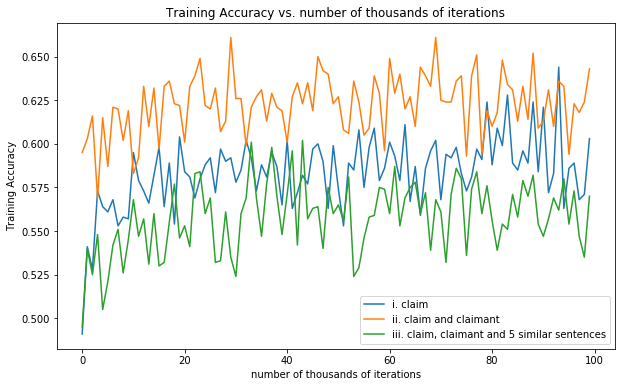

In [23]:
plt.figure(figsize=(10,6))
plt.plot(all_train_accuracies_i, label='i. claim')
plt.plot(all_train_accuracies_ii, label='ii. claim and claimant')
plt.plot(all_train_accuracies_iii, label='iii. claim, claimant and 5 similar sentences')

plt.xlabel('number of thousands of iterations')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. number of thousands of iterations')
plt.legend(loc='lower right')
plt.show()

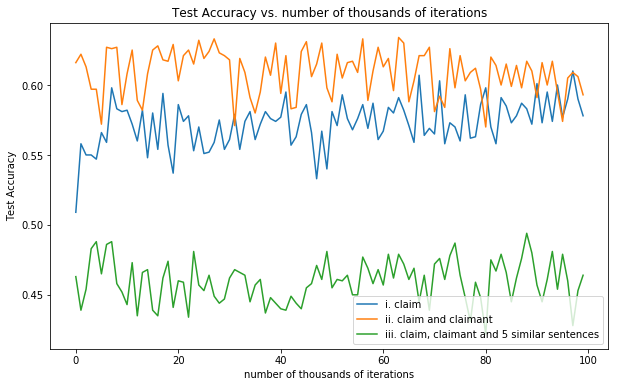

In [24]:
plt.figure(figsize=(10,6))
plt.plot(all_test_accuracies_i, label='i. claim')
plt.plot(all_test_accuracies_ii, label='ii. claim and claimant')
plt.plot(all_test_accuracies_iii, label='iii. claim, claimant and 5 similar sentences')

plt.xlabel('number of thousands of iterations')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. number of thousands of iterations')
plt.legend(loc='lower right')
plt.show()